# Imports

In [ ]:
from  utils import read_txt_file, write_csv_file
import pandas as pd

# Materials and Methods

## Datasets

The dataset **RB198** was employed as the training set, while **RB111** served as the independent set in this implementation.

 Both datasets were acquired from the following source: http://ailab-projects2.ist.psu.edu/RNABindRPlus/data.html

Originally, the data was structured as a text file in the following format:

```
#First line: PDBID and Chain ID
#Second line: Sequence
#Third line: Interface residues defined using a 5.0 angstrom distance cut-off
2XFZ_Y
KGFKDYGHDYHPAPKTENIKGLGDLKPGIPKTPKQNGGGKRKRWTGDKGRKIYEWDSQAGELEGYRASDGQHLGSFDPKTGNQLKGPDPKRNIKKYL
0000000011100000000000000000111011111111110000010110000111100000010110000000000000000000111101111
```

We needed to convert this data into a CSV file with the following features:

**PDBID**, **ChainID**, **Sequence**, **Interface**

The script processed this transformation.

In [ ]:
rb198txt = 'Datasets/RB198.txt'
rb198 = 'Datasets/RB198.csv'

data = read_txt_file(rb198txt)
write_csv_file(data, rb198)

rb111txt = 'Datasets/RB111.txt'
rb111 = 'Datasets/RB111.csv'
data = read_txt_file(rb111txt)
write_csv_file(data, rb111)

The structure of the dataframe resembles:

In [ ]:
train_data = pd.read_csv('Datasets/RB198.csv')
train_data.head(3)

,PDBID,ChainID,Sequence,Interface
0,2AZ0,A,MPSKLALIQELPDRIQTAVEAAMGMSYQDAPNNVRRDLDNLHACLN...,0000000000000000000000000000000010011001001100...
1,1M8V,A,GAMAERPLDVIHRSLDKDVLVILKKGFEFRGRLIGYDIHLNVVLAD...,0001110110010010000000000000000001111110000000...
2,2PJP,A,FSEEQQAIWQKAEPLFGDEPWWVRDLAKETGTDEQAMRLTLRQAAQ...,0000000000000000000001110000000001000100000000...


## Methodology

In this implementation, the proposed PRIP method comprised five steps:

1. Pre-training the Word2vec model.
2. Dividing protein sequences.
3. Extracting semantic features.
4. Training the XGBoost classifier.
5. Discerning between binding and non-binding sites.


## Word2Vec

In [ ]:
def split_protein_sequence(protein_sequence, segment_length):
    """
      Takes protein sequence and the length of resulting segments, and splits it into different segments by padding with X characters.
    """

    if segment_length % 2 == 0 :
        raise ValueError("Segment length must be an odd number and greater than or equal to 2*n + 1")

    segments = []
    sequence_length = len(protein_sequence)

    n = (segment_length - 1)// 2

    # Iterate over each residue in the protein sequence
    for i in range(sequence_length):
        # Determine the start and end indices of the segment
        start_index = max(0, i - n)
        end_index = min(sequence_length, i + n + 1)

        # Fill the segment with "X" characters at the start or end if needed
        if start_index == 0:
            padded_segment = "X" * (n - i) + protein_sequence[:end_index]
        elif end_index == sequence_length:
            padded_segment = protein_sequence[start_index:] + "X" * (n - (sequence_length - 1 - i))
        else:
            segment = protein_sequence[start_index:end_index]
            padded_segment = "X" * (n - (i - start_index)) + segment

        # Add the segment to list of segments
        segments.append(padded_segment)

    return segments

In [ ]:
# Concatenate semantic vectors for each residue
def feature_extract(segments , W2V_model):
    """ Extracts semantic vectors from segments , and returns thems concatenated """

    semantic_vect_concat = []
    for segment in segments :
        seg_vect = []
        for residue in segment :
            if residue != 'X' :
                seg_vect.extend(W2V_model.wv[residue])
            else:
                seg_vect.extend([0 for i in range(25)])
        semantic_vect_concat.append(seg_vect)

    return semantic_vect_concat


In [ ]:
from gensim.models import Word2Vec
import pandas as pd

def load_model(path):
    return Word2Vec.load(path)


In [ ]:
model = load_model("model_W2V.model")

df_train = pd.read_csv("RB198.csv")
df_test = pd.read_csv("RB111.csv")

protein_seqs_train = df_train['Sequence'].to_list()
label_interfaces_train = df_train['Interface'].to_list()


protein_seqs_test= df_test['Sequence'].to_list()
label_interfaces_test = df_test['Interface'].to_list()

pairs_train = list(zip(protein_seqs_train , label_interfaces_train))
pairs_test = list(zip(protein_seqs_test , label_interfaces_test))


In [ ]:
# Sequence splitting + assigning the interface labels for each split
X_train , y_train  , X_test , y_test = [] , [] , [] , []
segment_length = 39
for elem in pairs_train :
    prot_sequence = elem[0]
    label_interf = elem[1]

    if len(prot_sequence) < segment_length :
        print("inf")
    segments = split_protein_sequence(prot_sequence ,segment_length)

    # X represents the segments (sequences split) and y represents the respective labels
    X_train.extend(segments)
    y_train.extend(label_interf)

for elem in pairs_test :
    prot_sequence = elem[0]
    label_interf = elem[1]

    if len(prot_sequence) < segment_length :
        print("inf")
    segments = split_protein_sequence(prot_sequence ,segment_length)

    # X represents the segments (sequences split) and y represents the respective labels
    X_test.extend(segments)
    y_test.extend(label_interf)



In [ ]:
semantic_vects_train = feature_extract(X_train , model)
semantic_vects_test = feature_extract(X_test , model)

In [ ]:
y_train_int = [int(x) for x in y_train]
y_test_int = [int(x) for x in y_test]

y_train = y_train_int
y_test = y_test_int

In [ ]:
def sensitivity(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    return TP / (TP + FN)

def specificity(y_true, y_pred):
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    return TN / (TN + FP )

def matthews_coeff(y_true , y_pred):
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    return (TP * TN - FN * FP) / math.sqrt((TN+FN)*(TN+FP)*(TP+FN)*(TP+FP))



# Other models comparison
In this part, we want to compare how well does XGBoost do compared to other competing models, after fine-tuning, on the training set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve , make_scorer, matthews_corrcoef, ConfusionMatrixDisplay


# Hyper-parameters that we tried to tune on for each model
param_grids = {
    "XGBoost": {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'gamma': [0, 0.1, 0.2],
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "LightGBM": {
        'num_leaves': [31, 50],
        'learning_rate': [ 0.01, 0.001],
        'n_estimators': [100, 200]
    }
}

In [ ]:

# Create custom scorers using make_scorer
scoring = {
    'accuracy': 'accuracy',
    'auroc': 'roc_auc',
    'sensitivity': make_scorer(sensitivity),
    'specificity': make_scorer(specificity),
    'mcc': make_scorer(matthews_coeff)
}

best_params_models = []
for model_name, model in models:
    # Create GridSearchCV instance
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring=scoring, refit='accuracy' , error_score ='raise')

    # Perform grid search
    grid_search.fit(semantic_vects_train, y_train)

    # Print best parameters and best score
    print(f"Best parameters for {model_name}:", grid_search.best_params_)
    print(f"Best score for {model_name}:", grid_search.best_score_)

    best_params_models.append((model_name, grid_search.best_params_))


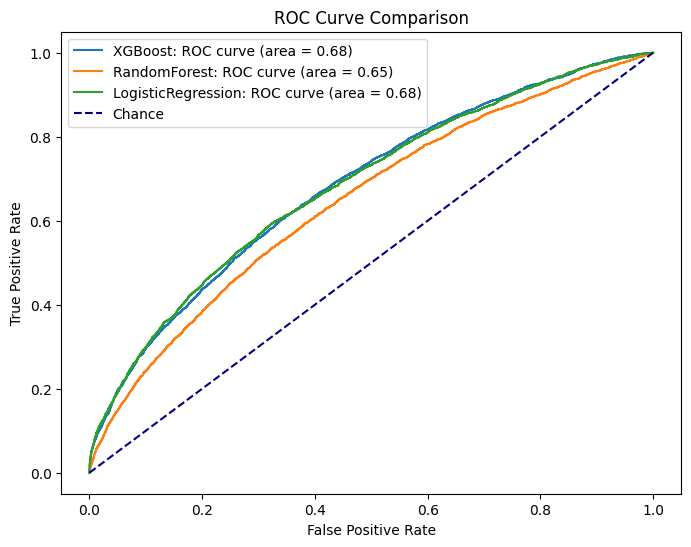

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# These are the overall best parameters that we got, for 3 models
# The other two were not tuned like expalined in the report
models = [
    ("XGBoost", XGBClassifier(objective='binary:logistic', n_estimators=100)),
    ("RandomForest", RandomForestClassifier()),
    ("LogisticRegression", LogisticRegression(max_iter=1000))
]


# Plot ROC curves for the best models
plt.figure(figsize=(8, 6))

for model_name, model in models:
    best_params = [params for name, params in best_params_models if name == model_name][0]
    model.set_params(**best_params)

    model.fit(semantic_vects_train, y_train)

    y_pred = model.predict(semantic_vects_test)
    y_pred_proba = model.predict_proba(semantic_vects_test)[:, 1]  # Predict probabilities for positive class

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)  # Compute AUROC

    plt.plot(fpr, tpr, label=f'{model_name}: ROC curve (area = %0.2f)' % auroc)

# Add the chance line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


# XGBoost accuracy on Independent set

In [ ]:
import numpy as np

best_params_models = {}

# These are the found best parameters, we put them directly to not go through fine-tuning again ...
best_params_models["XGBoost"] = {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5}


xgb_model = XGBClassifier(**best_params_models["XGBoost"])


# Train the model on the entire training dataset
xgb_model.fit(semantic_vects_train, y_train)


# Make predictions on the test set
y_pred = xgb_model.predict(semantic_vects_test)
y_pred_proba = xgb_model.predict_proba(semantic_vects_test)[:, 1]  # Predict probabilities for positive class

y_pred = np.array(y_pred)
y_test = np.array(y_test)
y_pred_proba = np.array(y_pred_proba)


Accuracy: 0.9130724174653887
AUROC: 0.6829977094016113
Matthews coefficient : 0.14638614836491953
Sensitivity: 0.04720121028744327
Specificity: 0.9966136330462706
Confusion Matrix:
[[34139   116]
 [ 3149   156]]


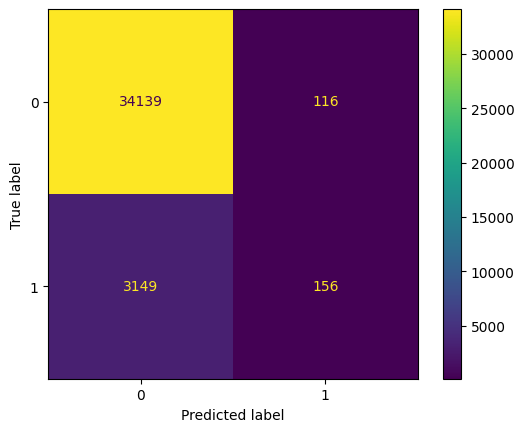

In [ ]:

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

auroc = roc_auc_score(y_test, y_pred_proba)
print("AUROC:", auroc)

mtcoeff = matthews_coeff(y_test, y_pred)
print("Matthews coefficient :", mtcoeff)

sensitivity = sensitivity(y_test, y_pred)
print("Sensitivity:", sensitivity)

specificity = specificity(y_test, y_pred)
print("Specificity:", specificity)

# DIsplay confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
dsp = ConfusionMatrixDisplay(cm)
dsp.plot();

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Compare ROC curves and AUROC areas

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

best_params_models.append(("XGBoost" ,{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5}))
best_params_models.append(("RandomForest", {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}))
best_params_models.append(("LogisticRegression" , {'C': 10, 'solver': 'lbfgs'}))

models = [
    ("XGBoost", XGBClassifier(objective='binary:logistic', n_estimators=100)),
    ("RandomForest", RandomForestClassifier()),
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("SVM", SVC(probability=True)),
    ("LightGBM", LGBMClassifier())
]


# Plot ROC curves for the best models
plt.figure(figsize=(8, 6))

for model_name, model in models:
    best_params = [params for name, params in best_params_models if name == model_name][0]
    model.set_params(**best_params)

    model.fit(semantic_vects_train, y_train)

    y_pred = model.predict(semantic_vects_test)
    y_pred_proba = model.predict_proba(semantic_vects_test)[:, 1]  # Predict probabilities for positive class

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name}: ROC curve (area = %0.2f)' % auroc)

# Add the chance line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


# WordCloud generation
We created pairs way up in the notebook. We can use them for the word clouds.

In [ ]:
sequences = X_train + X_test
y_test = list(y_test) ; y_train = list(y_train)
labs = y_train + y_test

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pairs = list(zip(X_train , y_train))
pos_words , neg_words = '' , ''         # Positive and negative instances (RNA-binding, and none-binding interfaces)
for sequence , label in pairs :
  for word in sequence :
    if word != 'X' :
      if label == 1 :
        pos_words += word + ' '
      else :
        neg_words += word + ' '

wordcloud = WordCloud().generate(neg_words)       # here change between beg_words/pos_words

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()